$\newcommand{\calf}{{\cal F}}
\newcommand{\dnu}{d \nu}
\newcommand{\dmu}{d \mu}
\newcommand{\dmup}{d \mu'}
\newcommand{\vf}{{\bf f}}
\newcommand{\vq}{{\bf q}}
\newcommand{\mg}{{\bf G}}
\newcommand{\mK}{{\bf K}}
$

In [20]:
include("nda_note.jl")

# Using the notebook

The first cell in this notebook is an invisible markdown cell with LaTeX commands. The second is a code cell that sets up the packages you'll need to load. It's best to do a __run all__ before experimenting with the solvers.

## Contents

[The equation and discretization](#The-Equation)

[Solvers](#Solvers)

- [GMRES and Source Iteration](#GMRES-and-Source-Iteration)

- [NDA Formulation](#NDA)

[QMC](#QMC)

  - [Validation and Calibration Study](#Validation-and-calibration-study)
  
  - [Timings](#Timings)
  
  - [QMC Questions](#QMC-questions)
  
  - [QMC and GMRES](#QMC-and-GMRES)

  - [QMC and NDA](#QMC-and-NDA)
  
[Docstrings for kl\_gmres and nosli](#Docstrings-for-kl\_gmres-and-nosli)

  - [Docstrings for kl\_gmres](#Docstrings-for-kl\_gmres.jl)
  
  - [Docstrings for nsoli](#Docstrings-for-nsoli.jl)

[References](ndaqmc.html)



# The equation

This note book compares various solvers for the problem in the Garcia/Siewert 
paper <cite data-cite="cesinh"><a href="ndaqmc.html#cesinh">(GS82)</cite>.  My formulation of the transport problem is taken from <cite data-cite="ctk:jeff1"><a href="ndaqmc.html#ctk:jeff1">(WKKP13b)</cite>. The equation for the angular flux $\psi$ is 

$$
\mu \frac{\partial \psi}{\partial x} (x,\mu) + \Sigma_t(x) \psi(x,\mu) =
\frac{1}{2} \left[ \Sigma_s(x) \int_{-1}^1 \psi(x, \mu') \dmup + q(x) \right]
 \mbox{ for } 0 \le x \le \tau
$$

The boundary conditions are

$$
\psi(0, \mu) = \psi_l(\mu), \mu > 0; \psi(\tau, \mu) = \psi_r(\mu),
\mu < 0.
$$
    
The notation is
    
   - $\psi$ is intensity of radiation or angular flux at point $x$ at angle $\cos^{-1} (\mu)$
   - $\phi = \phi(x) = \int_{-1}^{1}\psi(x,\mu) \ d\mu$ is the scalar flux, the $0^{th}$ angular moment of the angular flux.
    - $\tau < \infty$, length of the spatial domain.
    - $\Sigma_s \in C([0,\tau])$ is the scattering cross section at $x$
    - $\Sigma_t \in C([0,\tau])$ is the total cross section at $x$
    - $\psi_l$ and $\psi_r$ are incoming intensities at the bounds
    - $q \in C([0,\tau])$ is the fixed source
    
## Discretization    

The discretization is plain vanilla $S_N$ with diamond differencing. I'm storing fluxes (and later currents) at cell edges to make the boundary conditions for NDA a bit easier to deal with.

I'm using double Gaussian quadratures for the angular mesh. 
This means that the angles are N-point Gaussian quadratures on (-1,0) and on (0,1) for a total of 2N angles. The function __sn_angles.jl__ in the /src directory sets up the angular mesh. It uses the package __FastGaussQuadrature.jl__. We will denote the weights and notes of the angluar mesh by $w_j$ and $\mu_j$ for $j=1, ..., 2N$.

I'm using a uniform spatial mesh $\{ x_i \}_{i=1}^{N_x}$ where
$$
x_i = (i -1) dx \mbox{ and } dx = \tau/(N_x - 1).
$$
The function __sn_init.jl__ in /src sets up all the mesh data and boundary conditions. It builds a Julia named tuple for me to pass around to the solvers.

The disretization approximates the angular flux $\psi_i^j \approx \psi(x_i, \mu_j)$ and the scalar flux 
$$
\phi_i \approx \phi(x_i).
$$
The two approximations are related (in my cell-edge oriented code) by
$$
\mbox{Flux Equation:        } \phi_i =  \sum_{j=1}^{2N} \psi_i^j w_j 
$$

The discrete equation is, with source $S_i = \Sigma_s(x_i) f_i + q(s_i)$

$$
\begin{array}{ll}
\mbox{Transport Sweep:}
\\
\mu_j \frac{\psi_i^j - \psi_{i-1}^j}{dx} + \Sigma_t(x_i+dx/2) \frac{\psi_i^j + \psi_{i-1}^j}{2}
& = \frac{S_i + S_{i-1}}{2}
\mbox{ for $\mu_j > 0$ and $\psi_1^j = \psi(0,\mu_j)$}
\\
\mu_j \frac{\psi_i^j - \psi_{i+1}^j}{dx} + \frac{\psi_i^j + \psi_{i+1}^j}{2}
& = \frac{S_i + S_{i+1}}{2}
 \mbox{ for $\mu_j < 0$ and $\psi_{N_x}^j = \psi(\tau,\mu_j)$}
\end{array}
$$

So, source iteration begins with an initial iterate for the scalar flux $\phi$, computes the discrete scalar flux with the equations __Transport_Sweep__, treating $\vf$ as input data, and updates the scalar flux 
with the formula __Flux_Equation__. This can also be viewed as a linear equation for $\phi$
$$
\phi - \mK  \phi = f
$$
and solved with a Krylov method like GMRES. The right side of the integral equation depends on the source $q$ and the boundary data.

## The Garcia-Siewert Example

In this example
$$
\tau=5, \Sigma_s(x) =\omega_0 e^{-x/s},  \Sigma_t(x) = 1, q(x) = 0, \psi_l(\mu) = 1, \psi_r(\mu) = 0.
$$

# Solvers

The linear and nonlinear solvers come from my Julia package 
[SIAMFANLEQ.jl](https://github.com/ctkelley/SIAMFANLEquations.jl)
<cite data-cite="ctk:siamfanl"><a href="ndaqmc.html#ctk:siamfanl">(Kel20b)</cite>. 
The documentation for these codes is in the [Juila notebooks](https://github.com/ctkelley/NotebookSIAMFANL)
that accompany the package <cite data-cite="ctk:notebooknl"><a href="ndaqmc.html#ctk:notebooknl">(Kel20a)</cite>.
All of this is part of a book project
<cite data-cite="ctk:fajulia"><a href="ndaqmc.html#ctk:fajulia">(Kel20c)</cite>. The citations for these things may change as the book gets closer to publication. Please ask me before citing this stuff.
    
The important solvers for this notebook are the GMRES linear solver __kl_gmres.jl__ and the Newton-Krylov nonlinear solver __nsoli.jl__. 

## GMRES and Source Iteration

The function 
```compare.jl``` in the __src__ directory runs the source iteration and GMRES, plots the residual histories, and tabulates the exit disbributions for comparision with Tables 1 and 2 in the paper. As a sanity check I print the $L^\infty$ norm of the differences in the results from the two solvers. 

Here is a run for the first columns in the tables. 

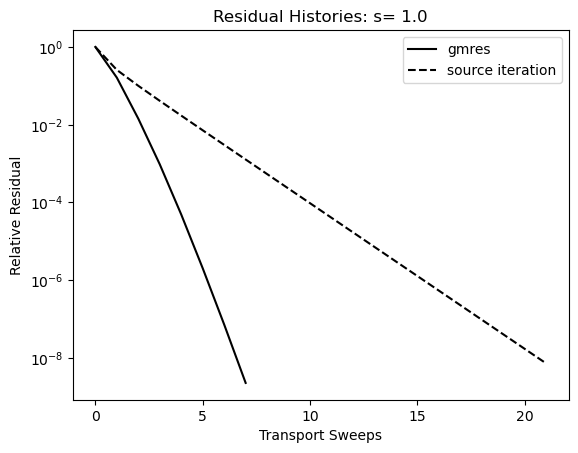

 mu         I(0,-mu)        I(tau,mu) 
 0.05     5.89670e-01     6.07486e-06 
 0.10     5.31120e-01     6.92514e-06 
 0.20     4.43280e-01     9.64229e-06 
 0.30     3.80307e-01     1.62338e-05 
 0.40     3.32965e-01     4.38575e-05 
 0.50     2.96091e-01     1.69371e-04 
 0.60     2.66564e-01     5.73462e-04 
 0.70     2.42390e-01     1.51281e-03 
 0.80     2.22235e-01     3.24369e-03 
 0.90     2.05175e-01     5.96035e-03 
 1.00     1.90547e-01     9.77122e-03 
Norm of result difference = 9.32897e-09


In [21]:
compare(1.0)

The functions all use precomputed data for the angles, spatial mesh, storage allocationf the angular flux, and various problem paramaters. The precomputed data lives in a named tuple ```sn_data``` which I create with ```ns_init.jl```. 

The iterations themselves use a transport sweep to do both source iteration and the liner residual computation for GMRES. In both cases a function ```flux_map!``` takes an input flux, does the transport sweep, and then takes the zeroth moment to return and output flux. The transport sweep is ```transport_sweep.jl``` it computes the angular flux from a given input flux and boundary conditions. 

Here is function for the source iteration solver. It's pretty simple if you believe ```flux_map.jl``` does what I say it does. I think the QMC version of ```flux_map.jl``` would fit in with this pretty easiliy. 

```
"""
 source_iteration(sn_data,s,tol)
 Source iteration example script for transport equation.

 This is one of the test cases from

 Radiative transfer in finite inhomogeneous plane-parallel atmospheres
 by Garcia and Siewert
 JQSRT (27), 1982 pp 141-148.

"""
function source_iteration(sn_data,s,tol=1.e-8)
    nx = 2001
    #
    # precomputed data
    #
    angles=sn_data.angles
    weihts=sn_data.weights
    itt = 0
    delflux = 1
    phi = zeros(nx)
    flux = zeros(nx)
    reshist = []
    while itt < 200 && delflux > tol
        flux = flux_map!(flux, sn_data)
        delflux = norm(flux - phi, Inf)
        itt = itt + 1
        push!(reshist, delflux)
        phi .= flux
    end
    #
    # Tabulate the exit distributions to check results.
    #
    return ( flux = flux, history= reshist)
end

```

Here are the results for the final column.

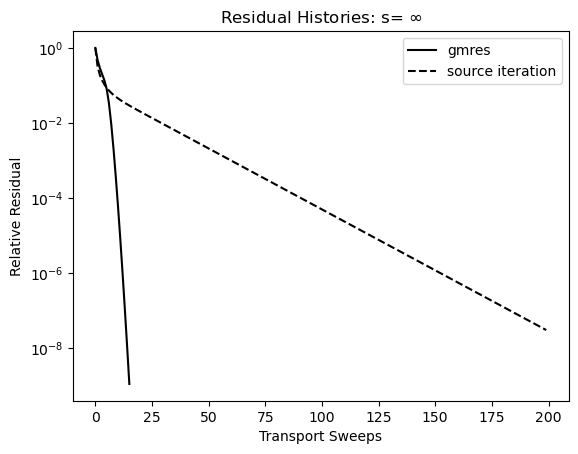

 mu         I(0,-mu)        I(tau,mu) 
 0.05     8.97799e-01     1.02201e-01 
 0.10     8.87836e-01     1.12164e-01 
 0.20     8.69581e-01     1.30419e-01 
 0.30     8.52299e-01     1.47701e-01 
 0.40     8.35503e-01     1.64497e-01 
 0.50     8.18996e-01     1.81004e-01 
 0.60     8.02676e-01     1.97324e-01 
 0.70     7.86493e-01     2.13507e-01 
 0.80     7.70429e-01     2.29571e-01 
 0.90     7.54496e-01     2.45504e-01 
 1.00     7.38721e-01     2.61279e-01 
Norm of result difference = 3.97115e-07


In [22]:
compare(Inf)

## NDA


NDA (nonlinear diffusion acceleration) turns the linear problem into a nonlinear one. One gets an equation for the (__low-order__) flux $f$ in terms of the moments of $\psi$. It is easier for me to explain this for the continuous problem. Be warned that my __boundary conditions are not standard__.

I'm taking this from 
<cite data-cite="ctk:jeff1"><a href="ndaqmc.html#ctk:jeff1">(WKKP13b)</cite>,
<cite data-cite="knollnda"><a href="ndaqmc.html#knollnda">(KPS11)</cite>, and
<cite data-cite="knoll08"><a href="ndaqmc.html#knoll08">(KPS08)</cite>.


Given a flux $\phi(x)$ we begin by solving a __high-order__ problem for an angular flux

$$
\mu \frac{\partial \psi^{HO}}{\partial x} + \Sigma_t\psi^{HO}(x,\mu)
= \frac{1}{2}\left[\Sigma_s \phi^{LO}(x) + q(x)\right],
$$
with the same boundary conditions we used in the original problem.

The next step is to compute high-order fluxes
$$
f^{HO}(x)= \int_{-1}^1 \psi(x, \mu') \dmu'
$$
and currents
$$
J^{HO}(x)= \int_{-1}^1 \psi(x, \mu') \mu' \dmu'.
$$

We use these to compute 
$$
{\hat D} = \frac{ J^{HO} + \frac{1}{3} \frac{d \phi^{HO}}{dx} } {\phi^{HO}},
$$
If $\phi$ is the solution to the __low-order__ problem, 
$$
\frac{d}{dx}\left[ -\frac{1}{3\Sigma_t} \frac{d\phi}{dx} + \hat{D} \phi\right] + (\Sigma_t - \Sigma_s)\phi = q,
$$
then $\phi$ is the scalar flux and we have solved the transport equation. The boundary conditions are tricky if we store fluxes and currents at cell centers. If we have cell edge fluxes, then boundary conditions
$$
\phi(0) = \phi^{HO}(0), \phi(\tau) = \phi^{HO}(\tau)
$$
work well.
    
The low-order prolbem is nonlinear because $\phi^{HO}$, $J^{HO}$ and $\hat D$ depend on $\phi$. We can make this explicit (writing ${\hat D}(\phi)$ and that helps when it's time to write code. Write the nonlinear equation as $F(\phi) = 0$ where
$$
F (\phi) = \frac{d}{dx}\left[ -\frac{1}{3\Sigma_t} \frac{d\phi}{dx} + \hat{D}(\phi) \phi\right] + (\Sigma_t - \Sigma_s)\phi - q.
$$

We can solve this equation efficiently with Newton-GMRES if we have a good preconditioner. We use fast solver for the high-order term in the low-order equation. The preconditioner in 
<cite data-cite="ctk:jeff1"><a href="ndaqmc.html#ctk:jeff1">(WKKP13b)</cite>,
<cite data-cite="knollnda"><a href="ndaqmc.html#knollnda">(KPS11)</cite>, 
<cite data-cite="knoll08"><a href="ndaqmc.html#knoll08">(KPS08)</cite>, is a bit more complicated. 

We can also formulate the low-order problem as a fixed point problem by viewing the solution of the low-order problem $\phi^{LO}$ as a transformation of $\phi$. So given $\phi^{LO}$ compute the high-order flux, current, and ${\hat D} = {\hat D}(\phi^{LO})$. Then solve 
$$
\frac{d}{dx}\left[ -\frac{1}{3\Sigma_t} \frac{d\phi}{dx} + \hat{D}(\phi^{LO}) \phi\right] + (\Sigma_t - \Sigma_s)\phi = q,
$$
For $\phi$. This is a __linear__ equation for $\phi$ because $\phi^{LO}$ is input. Express this as 
$$
\phi = G(\phi^{LO})
$$
We have solved the problem if $\phi=\phi^{LO}$. So a Picare or fixed point iteration is
$$
\phi_{n+1} = G(\phi_n).
$$

One can also solve
$$
F(\phi) = \phi - G(\phi)
$$
with a Newton-Krylov method. This is __not what we did__ in 
<cite data-cite="ctk:jeff1"><a href="ndaqmc.html#ctk:jeff1">(WKKP13b)</cite> because MC is not deterministic and we had to use a formula for the derivative of ${\hat D}$ with respect to $\phi$. Using that formula to differentiate $G$ would be a real pain. We can do this for QMC and use a finite-difference Jacobian-vector product. The advantage is that the conditioning of the linear system is better because we precondition when we solve low-order problem.
    
One subtle point for Newton is that we take on Picard iteration before starting Newton. The reason we do this is that the initial iterate $\phi = 0$ is really bad and Newton, while converging, takes many iterations to fix that. A single Picard sorts that out. 
    
The plots below compare the two approaches. The limited data in this note book indicate that GMRES is best for the $s=1$ case and NDA-Newton is best for $s = \infty$. The iteration histories overlap at the start because the first step for both is that single Picard. Note that I'm not counting Newton iterations but transport sweeps.


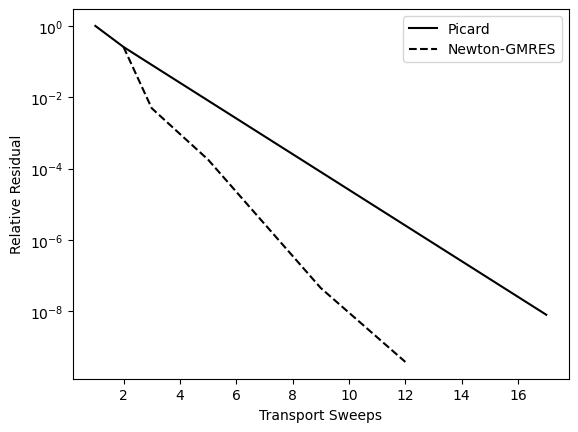

In [23]:
# Run for s=1
nda_compare(1.0);

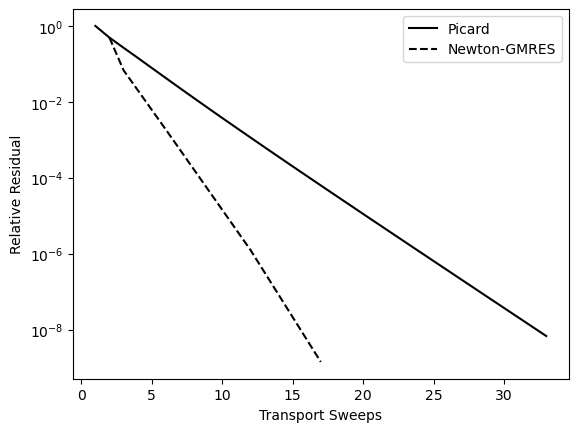

In [24]:
# and for s=Inf
nda_compare(Inf);

# QMC

## Validation and calibration study

I'll compare the results from the SN computation to what I get from Sam's QMC code. My SN results are for a very fine spatial mesh and fine enough angular mesh. They are good to at least six figures and I will regard them as exact for this study.

I will use the SN results for the table in the Garcia-Siewert paper and get results from QMC in the following way

- For a give N and Nx I will get cell average fluxes from Sam's code.
- I will use the same code to generate the tables that I used for the SN fluxes. That code is __src/sn_tabulate.jl__
- I will take the two 11 x 2 arrays of results DataSN and DataQMC and compoute componentwise relative error with

```
Derr = (DataSN-DataQMC)./DataSN
```
- I report the value ```norm(Derr,Inf)``` to measure the difference. 

Here one example. I have put the results from SN in two data files and can get the data by
```
DataSN = readdata(s)
```
where ```s=1``` or ```s=Inf```. 


In [25]:
s=1.0; N=10^3; Nx=100;
# Data from SN
DataSN=readdata(s);
# Results from QMC
DataQMC=tab_test(N, Nx;s=1.0)
# Results
[DataSN DataQMC]

11×4 Matrix{Float64}:
 5.89664e-01  6.07488e-06  5.68070e-01  5.85685e-06
 5.31120e-01  6.92516e-06  5.20190e-01  6.66967e-06
 4.43280e-01  9.64232e-06  4.40516e-01  9.25581e-06
 3.80306e-01  1.62339e-05  3.80344e-01  1.54476e-05
 3.32964e-01  4.38580e-05  3.34182e-01  4.09894e-05
 2.96090e-01  1.69372e-04  2.97850e-01  1.57446e-04
 2.66563e-01  5.73465e-04  2.68575e-01  5.36171e-04
 2.42390e-01  1.51282e-03  2.44506e-01  1.42483e-03
 2.22235e-01  3.24369e-03  2.24380e-01  3.07485e-03
 2.05174e-01  5.96036e-03  2.07305e-01  5.68065e-03
 1.90546e-01  9.77123e-03  1.92639e-01  9.35441e-03

The two columns on the left are the SN data and the ones on the right are the QMC results. It looks like there's about one figure accuracy. To find out we'll look at the component wise relative errors and take the max.

In [26]:
Derr = (DataSN-DataQMC)./DataSN

11×2 Matrix{Float64}:
  3.66209e-02  3.58891e-02
  2.05796e-02  3.68920e-02
  6.23422e-03  4.00852e-02
 -1.00351e-04  4.84361e-02
 -3.65658e-03  6.54075e-02
 -5.94406e-03  7.04174e-02
 -7.54578e-03  6.50321e-02
 -8.73353e-03  5.81647e-02
 -9.65139e-03  5.20523e-02
 -1.03831e-02  4.69284e-02
 -1.09806e-02  4.26580e-02

Looks like one to two figures. Taking the max gives me

In [27]:
norm(Derr, Inf)

7.04174e-02

So a bit better than one figure is what it is. The final part of this study is to make tables of these errors for varying N and Nx. The tables make complete sense, as I will explain after I show the results for ```s=1.0```. The code I use for this is the __qmc_vs_sn__ function in the file __src/validate.jl__. This thing takes a while to run and I'm not comopletely sure why. The next section on benchmarking explains my confusion.

In [28]:
qmc_vs_sn();

Nx\N :      1000         2000         4000         8000   
  50 :  1.40799e-01  1.36020e-01  1.34429e-01  1.35653e-01  
 100 :  7.04174e-02  6.56657e-02  6.48763e-02  6.50648e-02  
 200 :  4.74375e-02  3.26008e-02  3.19789e-02  3.20454e-02  
 400 :  5.14380e-02  1.99563e-02  1.59583e-02  1.60570e-02  
 800 :  5.42732e-02  2.20369e-02  1.30132e-02  8.19995e-03  
1600 :  5.66738e-02  2.31124e-02  1.45774e-02  4.41259e-03  


To understand the table we should first think of the idealized situation where the cell averages are from the __exact__ scalar flux. In that case all the collumns would be the same because $N = \infty$ in that case. The row error would decay by a factor of __four__ as Nx doubles because the fixed source problem I solve to make the tables is essentially a second order integration rule. But when you look at the __last__ column, you see only first order convergence. __Why is that?__ I may have a bug in my code, but the same table made for SN looks exactly like second order convergence.

For the earlier columns, there are not enough samples to fully populate the cells for the larger values of Nx, so the error stagnates. You see this on row three of the first column, for example. 

If you look at the rows, you'll see the O(1/N) error reduction from QMC. The last row (Nx=1600) does this well. The row just above (Nx = 800) shows that there is no benefit in increasing N once the fixed Nx has done the integration as well as it can. The Nx = 800 row shows reductios by roughly a factor as N --> 2N until N = 4000, then it stops because you've extracted all Nx=800 is able to give.

So the tables make some sense, but there are still things I do not understand.

The case $s = \infty$ is the same. Here's the table.

In [29]:
qmc_vs_sn(;s=Inf);

Nx\N :      1000         2000         4000         8000   
  50 :  5.67112e-02  2.21673e-02  1.18318e-02  1.27516e-02  
 100 :  5.38207e-02  2.13867e-02  1.15209e-02  6.25772e-03  
 200 :  5.42956e-02  2.18666e-02  1.26401e-02  4.56505e-03  
 400 :  5.12238e-02  2.05226e-02  1.31852e-02  4.52562e-03  
 800 :  9.17894e-02  1.76235e-02  1.42884e-02  4.13295e-03  
1600 :  5.82621e-02  2.03980e-02  1.39895e-02  3.98470e-03  


The $s = \infty$ case is a harder problem and we need larger values of $N$ to make progress. That last entry in column 1 tells me that I can't make sense of the results for the low value of $N$. The bottom line on this section is that things look reasonable, but ...

__Why does the error look first order in 1/Nx?__ This is what would happen if I left something out of a sum or missed and index in loop. But when I use the cell average fluxes from SN, I get second order and when I use the QMC cell averages fluxes (and change nothing else!) I get first order. Have I missed something?


## Timings

I use benchmark tools to see how the cost of QMC varies with N and Nx. The timings seem to tell me that the compute time is $O(N \times Nx)$. I do not understand why it's the product and not the sum? __Can someone explain this to me?__ In the experiment I increase N by a factor of two and the time goes up by that factor. Same results with Nx, so it looks like the time is proportional to the product.

In [30]:
N=1000; Nx=50;
println("Base Case")
@btime tab_test($N,$Nx);
N=2000; Nx=50;
println("Double N")
@btime tab_test($N,$Nx);
N=1000; Nx=100;
println("Double Nx")
@btime tab_test($N,$Nx);

Base Case
  25.582 ms (80410 allocations: 15.47 MiB)
Double N
  51.303 ms (160410 allocations: 30.85 MiB)
Double Nx
  47.928 ms (80412 allocations: 21.62 MiB)


## QMC questions

So I've got a few questions about these results. Most of this is coming from my ignorance of the details of QMC.

- I expected the errors to be $O(1/N) + O((1/Nx)^2)$, with very different prefactors in the $O$-terms, of course. Instead I see $O(1/N) + O(1/Nx)$. Is there theory for this?

- The timings tell me that the cost of the computation is $O(N \times Nx)$. I expected $O(N)$ with $Nx$ haveing very little effect. Why is this?

- Sam, the benchmark runs tell me QMC is allocating a lot. Can you fix this by, for example, preallocating some storage in the initialization. You might also look at the performance part of the Julia documentation to see if things like ```@inbounds``` and ```@simd``` might help the code run faster. The relevand part of the Julia manual is at https://docs.julialang.org/en/v1/manual/performance-tips/

## QMC and GMRES

I've reorganized what Sam gave me to make his __qmc_sweep__ function easy for me to call. I now have a file __src/Tim_QMC/gmres_test.jl__ that has most of the stuff I will need. The directory is not fully ready for prime time, but does do some useful work. 

I can solve the QMC linear problem with GMRES now and, just like the classical case, I'm seeing fewer than half of the number of transport sweeps. Herewith the results for N=1000 and Nx= 100.

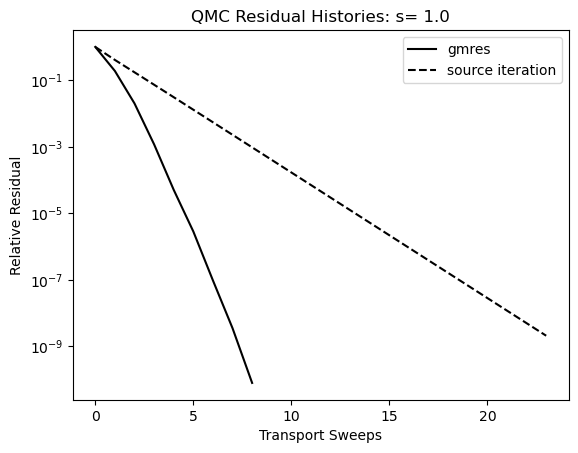

 mu         I(0,-mu)        I(tau,mu) 
 0.05     5.41377e-01     6.19654e-06 
 0.10     4.95177e-01     7.05674e-06 
 0.20     4.18303e-01     9.79509e-06 
 0.30     3.60686e-01     1.63614e-05 
 0.40     3.16659e-01     4.34676e-05 
 0.50     2.82085e-01     1.66405e-04 
 0.60     2.54267e-01     5.63406e-04 
 0.70     2.31418e-01     1.48908e-03 
 0.80     2.12325e-01     3.19881e-03 
 0.90     1.96135e-01     5.88723e-03 
 1.00     1.82235e-01     9.66388e-03 
Norm of result difference = 8.30118e-10


In [31]:
compare(1.0; qmc=true)

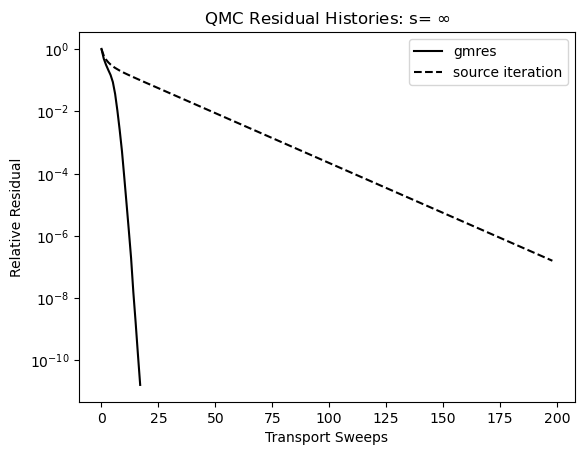

 mu         I(0,-mu)        I(tau,mu) 
 0.05     8.56444e-01     1.07382e-01 
 0.10     8.61791e-01     1.16885e-01 
 0.20     8.55775e-01     1.35706e-01 
 0.30     8.43735e-01     1.53595e-01 
 0.40     8.30112e-01     1.70906e-01 
 0.50     8.15817e-01     1.87844e-01 
 0.60     8.01139e-01     2.04512e-01 
 0.70     7.86216e-01     2.20966e-01 
 0.80     7.71144e-01     2.37235e-01 
 0.90     7.56004e-01     2.53316e-01 
 1.00     7.40873e-01     2.69192e-01 
Norm of result difference = 6.02327e-07


In [32]:
compare(Inf; qmc=true)

## QMC and NDA

What we need from QMC are

- cell average fluxes and currents, which I think we have and 
- cell average spatial derivatives for the high-order flux. 

As you can see from 
<cite data-cite="ctk:jeff1"><a href="ndaqmc.html#ctk:jeff1">(WKKP13b)</cite>,
it was not entirely trivial to get the spatial derivatives. 
    
I think Sam has given me what I need for this and I should get something done pretty soon.

# Docstrings for kl\_gmres and nosli

Nothing exciting here. I'll just fire up the help screens.

## Docstrings for kl\_gmres.jl

In [33]:
?kl_gmres

search: kl_gmres



kl_gmres(x0, b, atv, V, eta, ptv=nothing; kl_store=zeros(1,1);               orth = "cgs2", side="right", lmaxit=-1, pdata=nothing)

Gmres linear solver. Handles preconditioning and restarts.  Uses gmres_base which is completely oblivious to these things.

The deal is

Input:

x0:  initial iterate, this is usually zero for nonlinear solvers

b: right hand side (duh!)

atv:  matrix-vector product which depends on precomputed data pdta       I expect you to use pdata most or all of the time, so it is not       an optional argument, even if it's nothing (at least for now).        If your mat-vec is just A*v, you have to write a function where        A is the precomputed data.       API for atv is av=atv(v,pdata)

V:  Preallocated n x K array for the Krylov vectors. I store the initial     normalized residual in column 1, so  you have at most K-1 iterations     before gmres_base returns a failure. kl_gmres will handle the      restarts and, if lmaxit > 0, keep going until you hit lmaxit GMRES     iterations.

eta: Termination happens when ||b - Ax|| <= eta || b ||

ptv:  preconditioner-vector product, which will also use pdata. The       default is nothing, which is no preconditioning at all.       API for ptv is px=ptv(x,pdata)

Keyword arguments

kl_store: You may at some point have the option of giving me some room          for the vectors gmres needs to store copies of x0 and b,          which I will not overwrite and a couple of vectors I use          in the iteration. If you're only doing a linear solve, it          does no harm to let me allocate those vectores in kl_gmres.          If the solver is inside a loop, you should allocate this          storage. nsoli and ptscoli allocate this without your having          to do anything. Right now I'm not clear on an efficient way          to do this.

pdata: precomputed data. The default is nothing, but that ain't gonna         work well for nonlinear equations.

orth: your choice of the wise default, classical Gram-Schmidt twice,        or something slower and less stable. Those are classical once (really        bad) or a couple variants of modified Gram-Schmidt. mgs2 is what I        used in my old matlab codes. Not terrible, but far from great.

side: left or right preconditioning. The default is "right".

lmaxit: maximum number of linear iterations. The default is -1, which         means that the maximum number of linear iterations is K-1, which         is all V will allow without restarts. If lmaxit > K-1, then the         iteration will restart until you consume lmaxit iterations or         terminate successfully.

Other parameters on the way.

Output:

A named tuple (sol, reshist, lits, idid)

where

sol= final result reshist = residual norm history lits = number of iterations idid = status of the iteration        true -> converged         false -> failed to converge

# Examples:

In these examples you have the matrix and use 

```
function atv(x, A)
    return A * x
end
to compute the matvec.
```

#### Three dimensional problem. Will converge in the correct three iterations

only if you orthogonalize with CGS twice. 

```jldoctest
julia> function atv(x, A)
           return A * x
       end
atv (generic function with 1 method)

julia> A = [0.001 0 0; 0 0.0011 0; 0 0 1.e4];

julia> V = zeros(3, 10); b = [1.0; 1.0; 1.0]; x0 = zeros(3);

julia> gout = kl_gmres(x0, b, atv, V, 1.e-10; pdata = A);

julia> gout.reshist
4-element Array{Float64,1}:
 1.73205e+00
 1.41421e+00
 6.72673e-02
 1.97712e-34

julia> norm(b - A*gout.sol,Inf)
1.28536e-10
```

#### Integral equation. Notice that pdata has the kernel of the

operator and we do the matvec directly. Just like the previous example. We put the grid information and, for this artifical example, the solution in the precoputed data.

```jldoctest
julia> function integop(u, pdata)
           K = pdata.K
           return u - K * u
       end
integop (generic function with 1 method)

julia> function integopinit(n)
           h = 1 / n
           X = collect(0.5*h:h:1.0-0.5*h)
           K = [ker(x, y) for x in X, y in X]
           K .*= h
           sol = [usol(x) for x in X]
           f = sol - K * sol
           pdata = (K = K, xe = sol, f = f)
           return pdata
       end
integopinit (generic function with 1 method)

julia> function usol(x)
           return exp.(x) .* log.(2.0 * x .+ 1.0)
       end
usol (generic function with 1 method)

julia> function ker(x, y)
           ker = 0.1 * sin(x + exp(y))
       end
ker (generic function with 1 method)

julia> n=100; pdata = integopinit(n); ue = pdata.xe; f=pdata.f;

julia> u0 = zeros(size(f)); V = zeros(n, 20); V32=zeros(Float32,n,20);

julia> gout = kl_gmres(u0, f, integop, V, 1.e-10; pdata = pdata);

julia> gout32 = kl_gmres(u0, f, integop, V32, 1.e-10; pdata = pdata);

julia> [norm(gout.sol-ue,Inf) norm(gout32.sol-ue,Inf)]
1×2 Array{Float64,2}:
 4.44089e-16  2.93700e-07

julia> [gout.reshist gout32.reshist]
4×2 Array{Float64,2}:
 1.48252e+01  1.48252e+01
 5.52337e-01  5.52337e-01
 1.77741e-03  1.77742e-03
 1.29876e-19  8.73568e-11
```


## Docstrings for nsoli.jl

In [34]:
?nsoli

search: nsoli nda_nsoli nsol nsolsc



```
nsoli(F!, x0, FS, FPS, Jvec=dirder; rtol=1.e-6, atol=1.e-12,
           maxit=20, lmaxit=-1, lsolver="gmres", eta=.1,
           fixedeta=true, Pvec=nothing, pside="right",
           armmax=10, dx = 1.e-7, armfix=false, pdata = nothing,
           printerr = true, keepsolhist = false, stagnationok=false)
```

)

C. T. Kelley, 2021

Julia versions of the nonlinear solvers from my SIAM books.  Herewith: nsoli

You must allocate storage for the function and the Krylov basis in advance –> in the calling program <– ie. in FS and FPS

Inputs:

  * F!: function evaluation, the ! indicates that F! overwrites FS, your   preallocated storage for the function.

    So FS=F!(FS,x) or FS=F!(FS,x,pdata) returns FS=F(x)

  * x0: initial iterate

  * FS: Preallocated storage for function. It is an N x 1 column vector

  * FPS: preallocated storage for the Krylov basis. It is an N x m matrix where      you plan to take at most m-1 GMRES iterations before a restart.

  * Jvec: Jacobian vector product, If you leave this out the   default is a finite difference directional derivative.

    So, FP=Jvec(v,FS,x) or FP=Jvec(v,FS,x,pdata) returns FP=F'(x) v. 

    (v, FS, x) or (v, FS, x, pdata) must be the argument list,    even if FP does not need FS.   One reason for this is that the finite-difference derivative   does and that is the default in the solver.
  * Precision: Lemme tell ya 'bout precision. I designed this code for    full precision functions and linear algebra in any precision you want.    You can declare FPS as Float64 or Float32 and nsoli    will do the right thing. Float16 support is there, but not working well.

    If the Jacobian is reasonably well conditioned, you can cut the cost   of orthogonalization and storage (for GMRES) in half with no loss.    There is no benefit if your linear solver is not GMRES or if    othogonalization and storage of the Krylov vectors is only a   small part of the cost of the computation. So if your preconditioner   is good and you only need a few Krylovs/Newton, reduced precision won't   help you much.

---

Keyword Arguments (kwargs):

rtol and atol: relative and absolute error tolerances

maxit: limit on nonlinear iterations

lmaxit: limit on linear iterations. If lmaxit > m-1, where FPS has m columns, and you need more than m-1 linear iterations, then GMRES  will restart. 

The default is -1. This means that you'll take m-1 iterations, where size(V) = (n,m), and get no restarts.

lsolver: the linear solver, default = "gmres"

Your choices will be "gmres" or "bicgstab". However, gmres is the only option for now.

eta and fixed eta: eta > 0 or there's an error

The linear solver terminates when ||F'(x)s + F(x) || <= etag || F(x) ||

where 

etag = eta if fixedeta=true

etag = Eisenstat-Walker as implemented in book if fixedeta=false

The default, which may change, is eta=.1, fixedeta=true

Pvec: Preconditioner-vector product. The rules are similar to Jvec     So, Pv=Pvec(v,x) or Pv=Pvec(v,x,pdata) returns P(x) v where     P(x) is the preconditioner. You must use x as an input even     if your preconditioner does not depend on x

pside: apply preconditioner on pside, default = "right". I do not       recommend "left". See Chapter 3 for the story on this.

armmax: upper bound on step size reductions in line search

dx: default = 1.e-7

difference increment in finite-difference derivatives       h=dx*norm(x,Inf)+1.e-8

armfix: default = false

The default is a parabolic line search (ie false). Set to true and the step size will be fixed at .5. Don't do this unless you are doing experiments for research.

pdata:

precomputed data for the function/Jacobian-vector/Preconditioner-vector products.  Things will go better if you use this rather than hide the data  in global variables within the module for your function/Jacobian

If you use pdata in any of F!, Jvec, or Pvec, you must use in in all of them.

printerr: default = true

I print a helpful message when the solver fails. To suppress that message set printerr to false.

keepsolhist: default = false

Set this to true to get the history of the iteration in the output tuple. This is on by default for scalar equations and off for systems. Only turn it on if you have use for the data, which can get REALLY LARGE.

stagnationok: default = false

Set this to true if you want to disable the line search and either observe divergence or stagnation. This is only useful for research or writing a book.

Output:

  * A named tuple (solution, functionval, history, stats, idid,              errcode, solhist)

where

– solution = converged result

– functionval = F(solution)

– history = the vector of residual norms (||F(x)||) for the iteration

– stats = named tuple of the history of (ifun, ijac, iarm, ikfail), the  number of functions/Jacobian-vector prods/steplength reductions/linear solver failures at each iteration. Linear solver failures DO NOT mean that the nonlinear solver will fail. You should look at this stat if, for example, the line search fails. Increasing the size of FPS and/or lmaxit might solve the problem.

I do not count the function values for a finite-difference derivative because they count toward a Jacobian-vector product.

– idid=true if the iteration succeeded and false if not.

– errcode = 0 if if the iteration succeeded

```
    = -1 if the initial iterate satisfies the termination criteria

    = 10 if no convergence after maxit iterations

    = 1  if the line search failed
```

– solhist:

```
  This is the entire history of the iteration if you've set
  keepsolhist=true
```

solhist is an N x K array where N is the length of x and K is the number of iteration + 1. So, for scalar equations, it's a row vector.

---

# Examples

#### Simple 2D problem. You should get the same results as for nsol.jl because

GMRES will solve the equation for the step exactly in two iterations. Finite difference Jacobians and analytic Jacobian-vector products for full precision and finite difference Jacobian-vector products for single precision.

```jldoctest
julia> function f!(fv,x)
       fv[1]=x[1] + sin(x[2])
       fv[2]=cos(x[1]+x[2])
       end
f! (generic function with 1 method)

julia> function JVec(v, fv, x)
       jvec=zeros(2,);
       p=-sin(x[1]+x[2])
       jvec[1]=v[1]+cos(x[2])*v[2]
       jvec[2]=p*(v[1]+v[2])
       return jvec
       end
JVec (generic function with 1 method)

julia> x0=ones(2,); fv=zeros(2,); jv=zeros(2,2); jv32=zeros(Float32,2,2);

julia> jvs=zeros(2,3); jvs32=zeros(Float32,2,3);

julia> nout=nsol(f!,x0,fv,jv; sham=1);

julia> kout=nsoli(f!,x0,fv,jvs,JVec; fixedeta=true, eta=.1, lmaxit=2);

julia> kout32=nsoli(f!,x0,fv,jvs32; fixedeta=true, eta=.1, lmaxit=2);

julia> [nout.history kout.history kout32.history]
5×3 Array{Float64,2}:
 1.88791e+00  1.88791e+00  1.88791e+00
 2.43119e-01  2.43120e-01  2.43119e-01
 1.19231e-02  1.19231e-02  1.19231e-02
 1.03266e-05  1.03261e-05  1.03273e-05
 1.46416e-11  1.40862e-11  1.45457e-11
```
